# Optimization of a stopping strategy 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### Basic functions and Monte-Carlo

In [2]:
def simul_s(S0, sigma, dt, N, nb_traj, seed = 42):
    
    np.random.seed(seed)
    
    #epsilon est une matrice qui nous génère aléatoirement des valeurs suivant une lois gaussienne
    epsilon=np.random.randn(nb_traj, N+1)
    
    #on utilise la formule de réucrrence fournie, on commence par calculer la composante en exponentielle 
    #pour chaque élément de la matrice
    exp_epsilon=np.exp(-(1/2)*(sigma**2)*dt+sigma*np.sqrt(dt)*epsilon)
    
    #on affecte la valeur S0 à tous les éléments de la première colonne
    exp_epsilon[:, 0] = S0
    
    #on applique la formule de récurrence en utilisant la fonction cumprod de la bibliothèque numpy
    trajectories=np.cumprod(exp_epsilon,axis=1)
    
    return trajectories    

In [5]:
def s_to_a(trajectories):
    denominateurs = np.arange(1, np.shape(trajectories)[1]+1)
    trajectories_mean=np.cumsum(trajectories,axis=1)/denominateurs
    print (np.shape(trajectories[0]))
    return trajectories_mean

In [7]:
s_to_a(simul_s(10,0.2,1/252,10,100,seed=42))

(11,)


array([[10.        ,  9.99090163, 10.01486456, ..., 10.22856889,
        10.25643458, 10.27359771],
       [10.        , 10.01486743,  9.93993863, ...,  9.57714501,
         9.55167864,  9.52836816],
       [10.        ,  9.91066027,  9.85824572, ...,  9.69770495,
         9.69898192,  9.69980657],
       ...,
       [10.        ,  9.97022975,  9.97453899, ...,  9.97938978,
         9.95646954,  9.9328786 ],
       [10.        , 10.05344574, 10.05622872, ..., 10.16753593,
        10.20156552, 10.22621982],
       [10.        ,  9.99509513,  9.99163472, ..., 10.062358  ,
        10.05943794, 10.06096645]])

(100, 101)


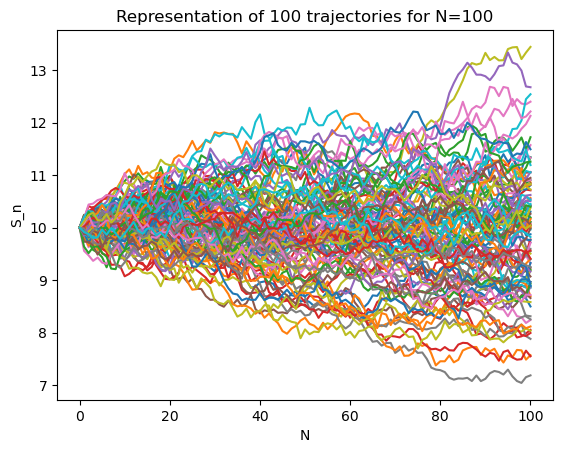

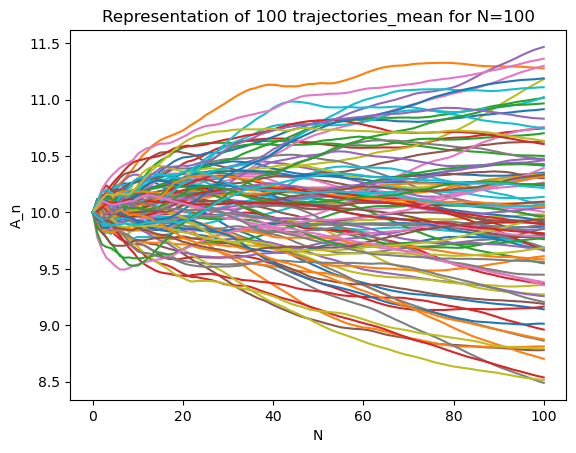

In [37]:
#réalisation de graphes pour vérifier le fonctionnement des fonctions

trajectories=simul_s(10,0.2,1/252,100,100,seed=42)
trajectories_mean=s_to_a(trajectories)
print(np.shape(trajectories_mean))

plt.plot(trajectories.T)
plt.xlabel('N')
plt.ylabel('S_n')
plt.title('Representation of 100 trajectories for N=100')
plt.show()

plt.plot(trajectories_mean.T)
plt.xlabel('N')
plt.ylabel('A_n')
plt.title('Representation of 100 trajectories_mean for N=100')
plt.show()

In [38]:
# Dans le reste du projet, nous utiliserons l'échantillon trajectories_test pour appliquer la méthode de Monte-Carlo

trajectories_test=simul_s(10,0.2,1/252,22,1000,seed=42)

In [39]:
def montecarlo(trajectories):
    
    trajectories_mean=s_to_a(trajectories)
    
    #div correspond à la matrice (A_n)/(S_n)
    div=trajectories_mean/trajectories
    
    #on souhaite estimer l'espérance sur la dernière colonne
    column_N=div[:, -1]
    estimate_expectation = np.mean(column_N)
    
    #calcul de l'intervalle de confiance
    std_dev = np.std(column_N)
    confidence_interval=estimate_expectation-1.96 * std_dev/np.sqrt(2**15), estimate_expectation+1.96 * std_dev/np.sqrt(2**15)
    
    return f"The value of the estimated expectation is {estimate_expectation:.4f} with a confidence interval [{confidence_interval[0]:.4f} ; {confidence_interval[1]:.4f}]."

L'expression mathématique de l'espérance est : $E\left[\frac{A_N}{S_N}\right] = \frac{1}{N+1} \cdot \frac{1 - \exp\left((N+1)\sigma^2\Delta t\right)}{1 - \exp\left(\sigma^2\Delta t\right)}$

In [40]:
montecarlo(trajectories_test)

'The value of the estimated expectation is 1.0019 with a confidence interval [1.0015 ; 1.0023].'

In [41]:
calculated_expectation = (1/(22+1)) * ((1 - math.exp((22+1)*0.2**2*(1/252))) / (1 - math.exp(0.2**2*(1/252))))
print(f"The value of the calculated expectation is {calculated_expectation:.4f}.")

The value of the calculated expectation is 1.0017.


On peut en déduire que notre estimateur de Monte-Carlo est bon, car la valeur théorique de l'espérance calculée (pour les paramètres utilisés dans l'estimateur), est comprise dans l'intervalle de confiance.

### Strategy and optimization

In [42]:
def strat_ratio(a,trajectories):
    trajectories_mean=s_to_a(trajectories)
    div=trajectories_mean/trajectories
    
    # indices est un tableau de taille nb_traj
    # Il renvoie pour chaque ligne, l'indice du premier élément qui vérifie la condition >= a
    # si dans une ligne aucun élément ne vérifie la condition il affecte la valeur 0
    indices = np.argmax(div >= a, axis=1)

    # Values est un tableau qui comporte la valeur maximale de chaque ligne de la matrice div
    values = np.max(div, axis=1)
    
    # ici on souhaite remplacer, pour les lignes de div où aucun élément ne vérifie la condition,
    # la valeur de l'indice qui est à 0 par N.
    # cependant il faut faire attention car dans certains cas il se peut élément que le premier élément
    # qui vérifie la condition soit l'élément d'indice 0! C'est pour cela qu'on utilise la condition sur values.

    indices[values < a] = div.shape[1]-1

    # On extrait les éléments correspondants
    stopped_values = div[np.arange(div.shape[0]), indices]
    
    # on estime l'espérance selon la méthode Monte-Carlo
    estimate_expectation=np.mean(stopped_values)
    
    # calcul de l'intervalle de confiance à 95%
    std_dev = np.std(stopped_values)
    confidence_interval=estimate_expectation-1.96 * std_dev/np.sqrt(2**15), estimate_expectation+1.96 * std_dev/np.sqrt(2**15)
    return_mssg=f"The value of the estimated expectation is {estimate_expectation:.4f} with a confidence interval [{confidence_interval[0]:.4f} ; {confidence_interval[1]:.4f}]."

    return estimate_expectation,return_mssg

In [43]:
strat_ratio(1.01,trajectories_test)

(1.0101698002135953,
 'The value of the estimated expectation is 1.0102 with a confidence interval [1.0100 ; 1.0104].')

In [44]:
def optimal_a(trajectories):
    a_list = np.arange(1, 1.5, 10**-5)
    E_list=[strat_ratio(a_list[i],trajectories)[0] for i in range(len(a_list))]
    indice_max=np.argmax(E_list)
    plt.plot(a_list,E_list)
    plt.xlabel('a')
    plt.ylabel('Value of the expectation')
    plt.title('Evolution of the expectation in function of a')
    plt.show()
    return f"The optimal value for a is {a_list[indice_max]:.4f}."

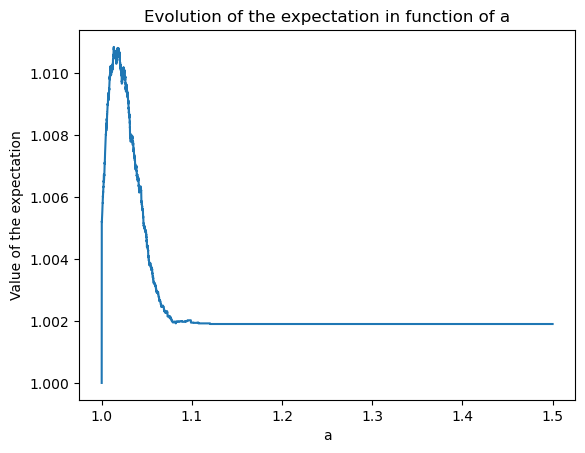

'The optimal value for a is 1.0134.'

In [45]:
optimal_a(trajectories_test)